# 6.6: Sourcing and Analysing Time Series Data

## This script contains the following:

### 1. Importing libraries and data

### 2. Subsetting and wranging data

### 3. Creating a line chart of the data

### 4. Decomposing data components

### 5. Testing for stationarity

### 6. Stationarising data

### 7. Checking autocorrelisation


### 1. Importing libraries and data

In [1]:
import nasdaqdatalink
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings 

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

nasdaqdatalink.ApiConfig.api_key = 'QsDNitzeKquzNTtAqxAi'

In [3]:
# Import Zillow data

data = nasdaqdatalink.get_table('ZILLOW/DATA')

In [4]:
data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2024-07-31,486230.166077
1,ZSFH,99999,2024-06-30,485893.210056
2,ZSFH,99999,2024-05-31,484599.091201
3,ZSFH,99999,2024-04-30,481777.608669
4,ZSFH,99999,2024-03-31,480423.651093


In [5]:
data.shape

(10000, 4)

In [6]:
data.columns

Index(['indicator_id', 'region_id', 'date', 'value'], dtype='object')

### 2. Subsetting and wrangling data

In [7]:
# Subset data to exclude 2020 onwards as data is likely to be biased due to Covid pandemic influence

data_sub = data.loc[(data['date'] >= '1996-01-01') & (data['date'] < '2020-01-01') & (data['region_id'] == '99999')]

In [8]:
# Remove unnecessary columns

data_value = data_sub[['date', 'value']]

In [9]:
data_value.head()

,date,value
None,,
55,2019-12-31,367461.089551
56,2019-11-30,364871.841511
57,2019-10-31,362052.638747
58,2019-09-30,359440.697810
59,2019-08-31,358180.258068


The dataset I chose (Zillow house prices) had data for every Zip code in the U.S. for every month of the year. In order to have one value that I could use in a time-series analysis, I chose to only concentrate on one Zip code. I also chose to only use data up to 2020, to avoid the influence of the Covid pandemic biasing the analysis. I removed any columns that were unrelated to the time-series analysis.  

In [10]:
# Set the 'date' column as the index

from datetime import datetime

data_value['datetime'] = pd.to_datetime(data_value['date'])
data_value = data_value.set_index('datetime')
data_value.drop(['date'], axis=1, inplace=True)
data_value.head()

,value
datetime,
2019-12-31,367461.089551
2019-11-30,364871.841511
2019-10-31,362052.638747
2019-09-30,359440.697810
2019-08-31,358180.258068


In [11]:
data_value.tail()

,value
datetime,
2005-05-31,169868.0
2005-04-30,167105.0
2005-03-31,165721.0
2005-02-28,164998.0
2005-01-31,164988.0


### 3. Creating a line chart of the data

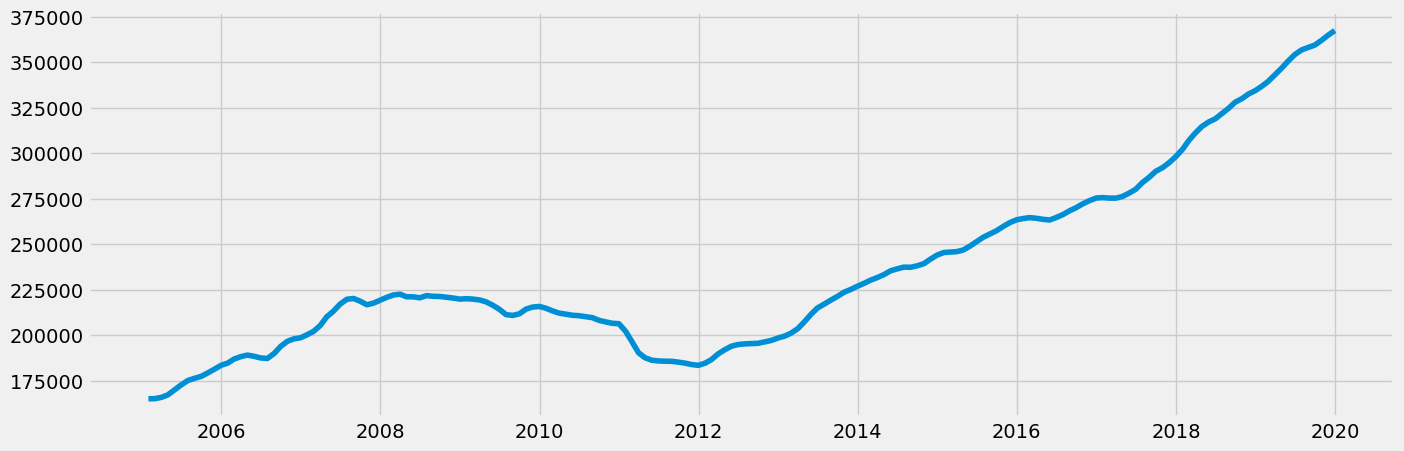

In [12]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
    

plt.plot(data_value)

In [13]:
# Check for missing values

data_value.isnull().sum()

value    0
dtype: int64

In [14]:
# Check for duplicates

dups = data_value.duplicated()

In [15]:
dups.shape # No duplicates

(180,)

### 4. Decomposing data components

In [17]:
decomposition = sm.tsa.seasonal_decompose(data_value, model='additive', period=12)

In [18]:
# Define fixed size for special charts

from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

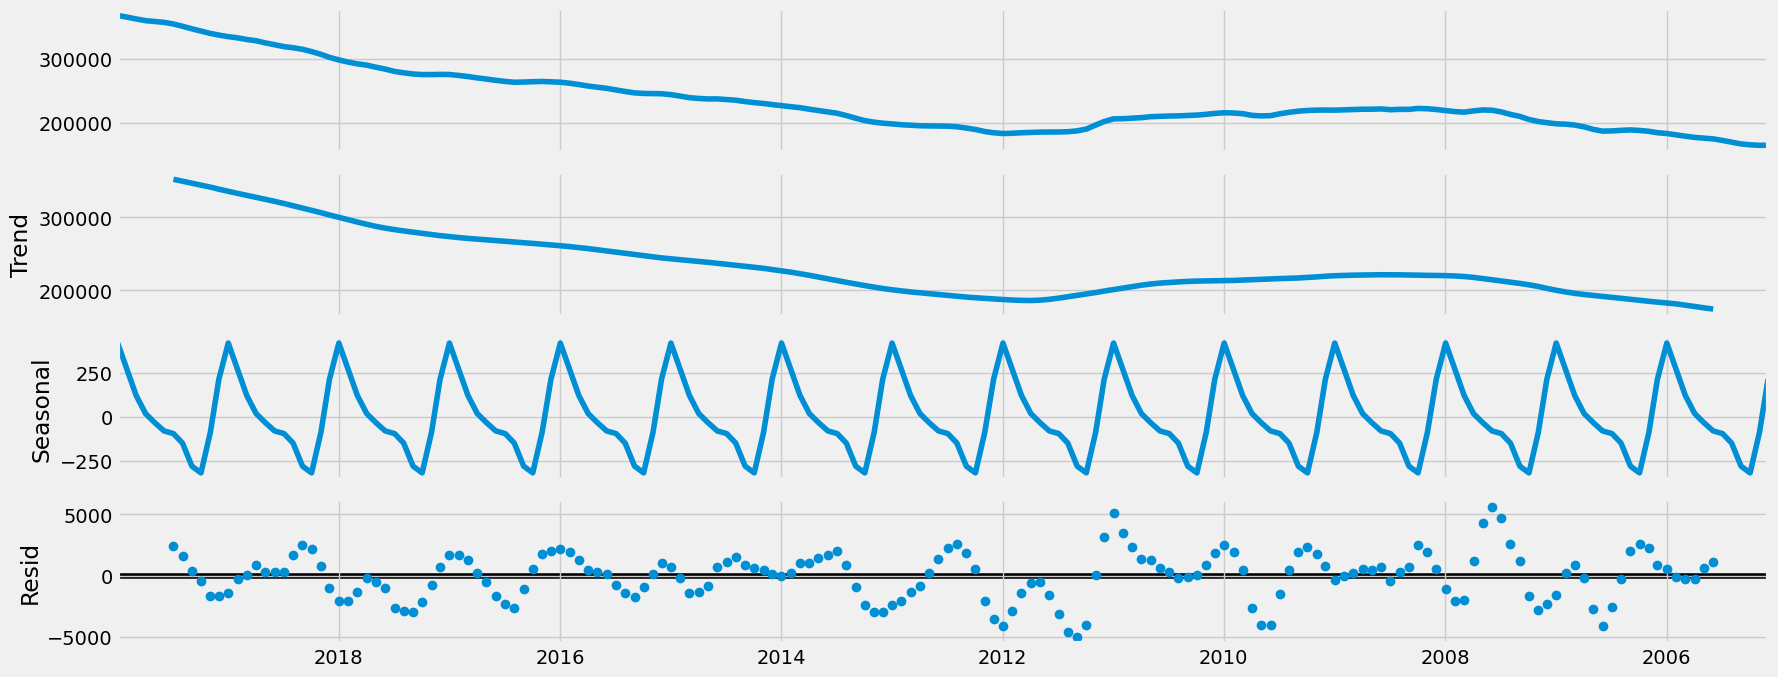

In [19]:
# Plot separate components

decomposition.plot()
plt.show()

It is clear from the plot above that there is an upward trend - house prices have largely increased year-on-year. The dip shown between 2009 and 2012 could possibly be explained by the global financial crisis that took place towards the end of 2008. Apart from that period, we could call the increase in house prices a dominant trend.

We can see yearly seasonality in the above plot. The National Association of Realtors is one of many bodies that state this, saying that house prices can be up to 16% more expensive between April and June as they are between December and February. This can often be explained by people prefering to move in warmer weather and in time for the beginning of the school year (https://tinyurl.com/5e4eepbf).

Although there is some noise shown above, the values used are monthly, so there should not be any need for smoothing.

### 5. Testing for stationarity

In [47]:
# Conduct Dickey-Fuller test

# Import the adfuller() function

from statsmodels.tsa.stattools import adfuller 

# Define the function

def dickey_fuller(timeseries): 
    
# Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_value['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.647030
p-value                          0.458590
Number of Lags Used             14.000000
Number of Observations Used    165.000000
Critical Value (1%)             -3.470616
Critical Value (5%)             -2.879221
Critical Value (10%)            -2.576197
dtype: float64


My null hypothesis is that a unit root is present in the data (non-stationary data), while the alternative hypothesis is that there is no unit root (meaning the data is stationary). For the null hypothesis to be disproven, the test statistic would need to be smaller than the critical values chosen. For a significant result, the p-value would need to be below 0.05.

As we can see from the Dickey-Fuller test result, the test statistic is larger than all of the critical values shown and the p-value is much higher than 0.05. Therefore, this data is non-stationary and the null hypothesis cannot be disproven.

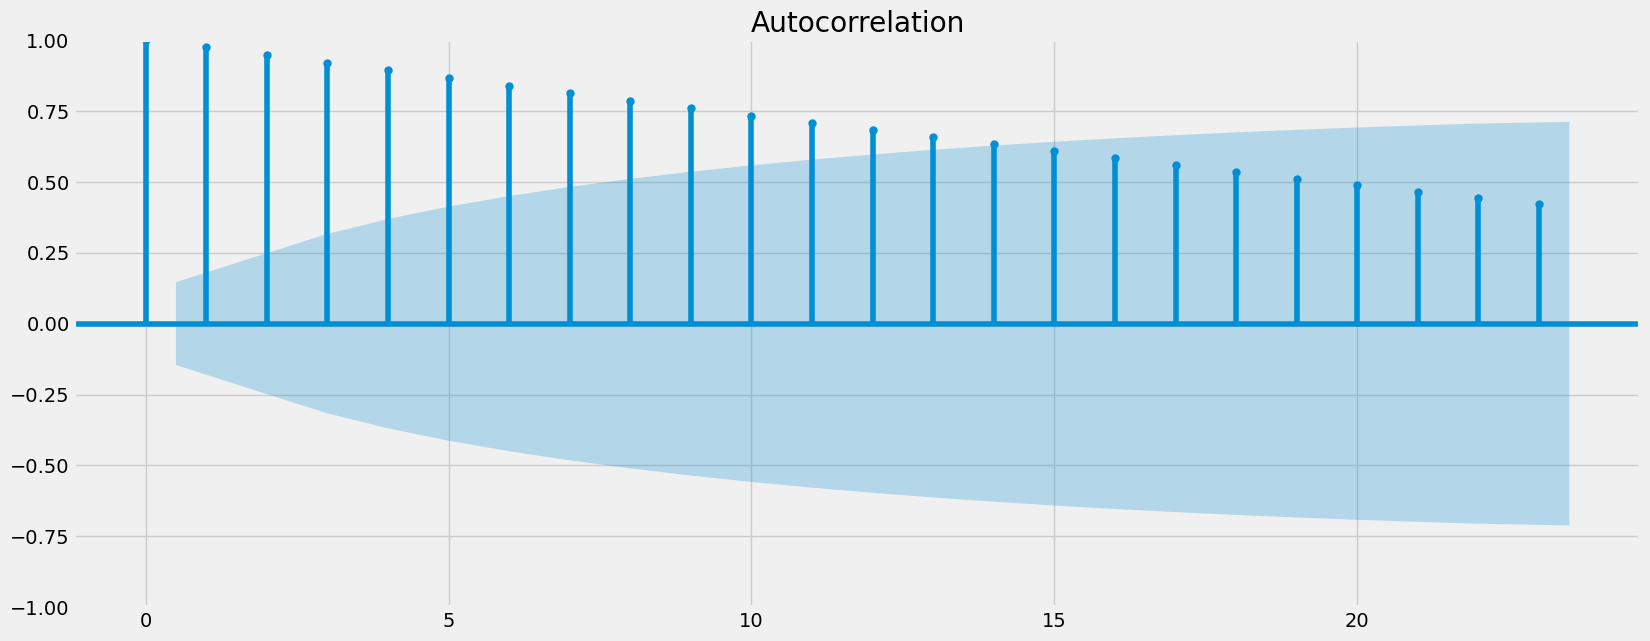

In [22]:
# Plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_value)
plt.show()

The Dickey-Fuller test showed that the data was non-stationary and the plot above corroborates that. With 15 significant lags, it is clear that this data is in need of differencing to make it stationary.

### 6. Stationarising data

In [23]:
data_diff = data_value - data_value.shift(1)

In [24]:
data_diff.head()

,value
datetime,
2019-12-31,NaN
2019-11-30,-2589.248040
2019-10-31,-2819.202764
2019-09-30,-2611.940937
2019-08-31,-1260.439742


In [25]:
data_diff.columns

Index(['value'], dtype='object')

In [27]:
# Check to see how many missing values are present

data_diff.isnull().sum()

value    1
dtype: int64

In [28]:
# Drop missing value created by differencing

data_diff.dropna(inplace = True)

In [29]:
# Check to see how many missing values are present after drop

data_diff.isnull().sum()

value    0
dtype: int64

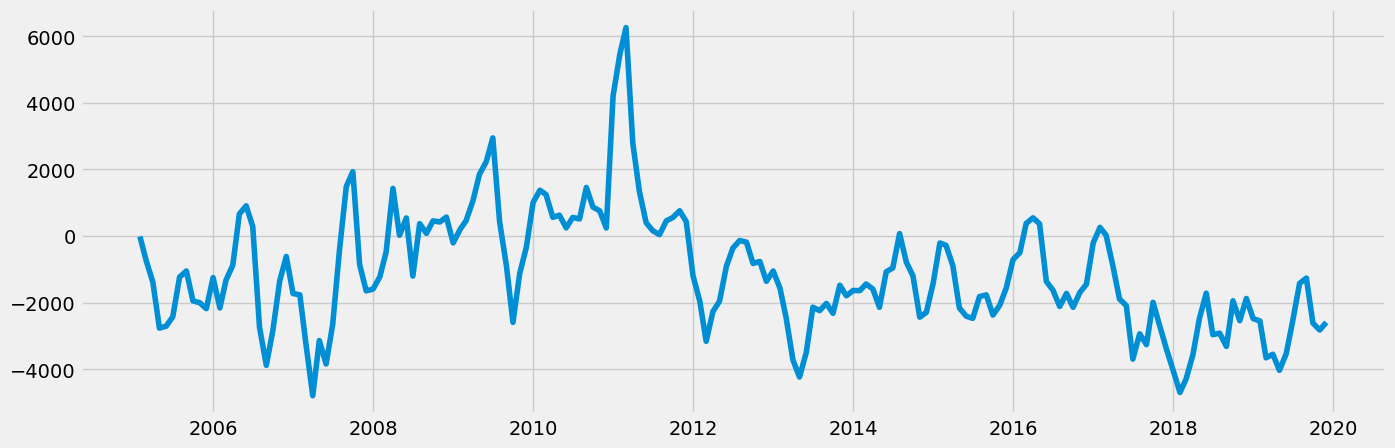

In [30]:
# Check time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [32]:
# Apply the test using the function on the time series

dickey_fuller(data_diff['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.333944
p-value                          0.161254
Number of Lags Used             14.000000
Number of Observations Used    164.000000
Critical Value (1%)             -3.470866
Critical Value (5%)             -2.879330
Critical Value (10%)            -2.576255
dtype: float64


The test statistic is still larger than the critical values, although the difference has been reduced, along with the p-value. However, I will perform another round of differencing as the data is still not stationary.

In [33]:
# Conduct 2nd round of differencing

data_diff_2 = data_diff - data_diff.shift(1)

In [34]:
data_diff_2.head()

,value
datetime,
2019-11-30,NaN
2019-10-31,-229.954725
2019-09-30,207.261827
2019-08-31,1351.501195
2019-07-31,-160.328251


In [36]:
data_diff_2.columns

Index(['value'], dtype='object')

In [42]:
# Drop missing value created by differencing

data_diff_2.dropna(inplace = True)

In [43]:
# Check to see how many missing values are present

data_diff_2.isnull().sum()

value    0
dtype: int64

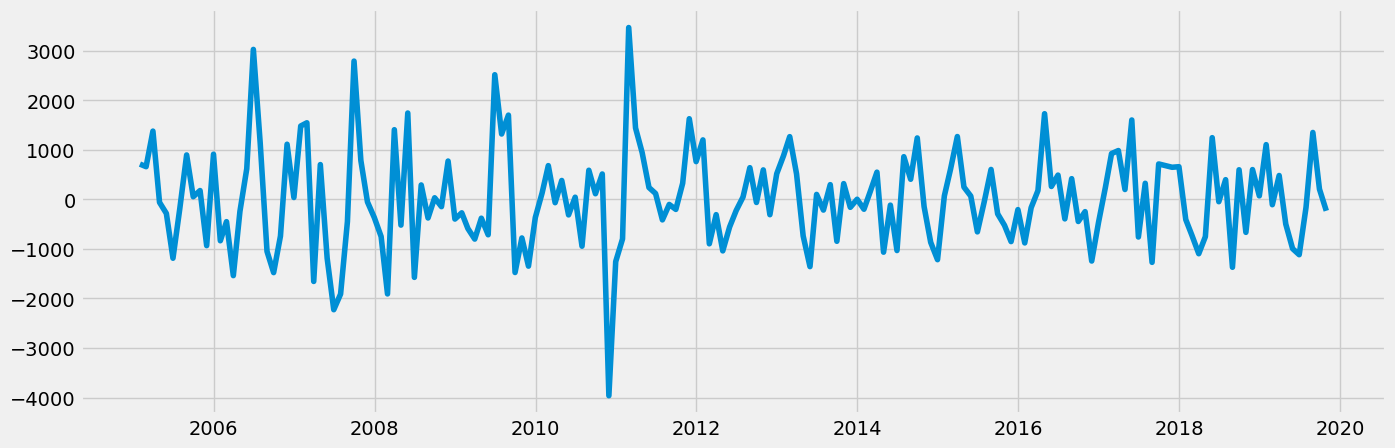

In [44]:
# Check time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [45]:
# Apply the test using the function on the time series

dickey_fuller(data_diff_2['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -4.450708
p-value                          0.000241
Number of Lags Used             14.000000
Number of Observations Used    163.000000
Critical Value (1%)             -3.471119
Critical Value (5%)             -2.879441
Critical Value (10%)            -2.576314
dtype: float64


After a second round of differencing, the p-value is below 0.05. The test statistic is now smaller than each of the critical values, meaning that there is no unit root in the data, and t Therefore, the alternative hypothesis can be proven and the data has now been made stationary.

### 7. Checking autocorrelation

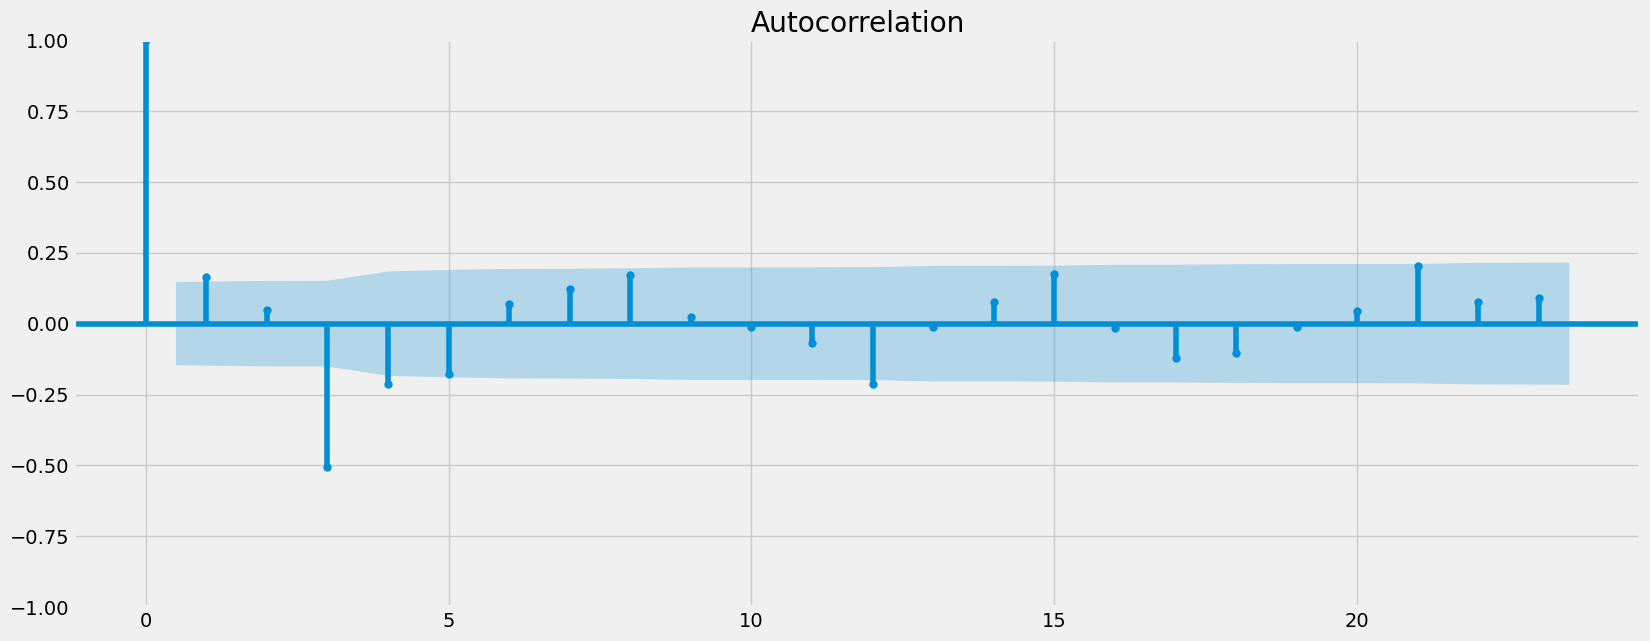

In [46]:
# Plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff_2)
plt.show()

There are now only three lags above the confidence level and the autocorrelation plot has improved significantly. I believe this shows that the stationarity is strong enough and that another round of differencing is unnecessary and could possibly result in over- or under-differencing.